# 본 프로젝트는 시장데이터 혹은 거시적 변수를 활용해 국면을 분석하여 국면에 따라 어떤 섹터가 아웃퍼폼하는지 나타내는 코드입니다.

In [60]:
import pandas as pd
import os
import time
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import FinanceDataReader as wb
import datetime
import numpy as np
from scipy.signal import savgol_filter


In [61]:

all_data=pd.read_csv('데이터정리_일간비교.csv', encoding='cp949').set_index('Date')

header= all_data.index.tolist()
H= list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), header))
all_data.index= H

In [62]:
all_data.loc[all_data.duplicated()]
data=all_data.loc['2001':,'KRW/USD'].dropna()
#all_data.index.is_unique

<AxesSubplot:>

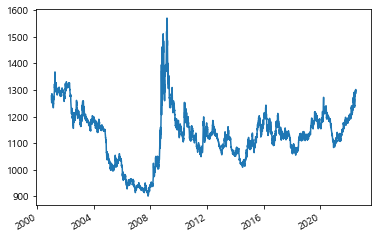

In [63]:
data.plot()

<AxesSubplot:>

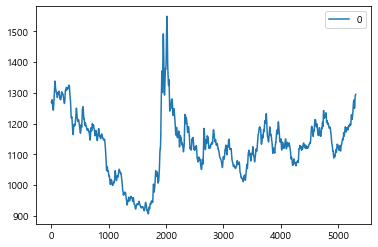

In [118]:

#len(savgol_filter(np.array(data).reshape(-1), 51, 3)),len(data)
pd.DataFrame(savgol_filter(np.array(data).reshape(-1), 21, 3)).plot()

## 데이터를 데이터프레임 형태로 넣어줘야합니다. NAN 값이 있으면 안되므로 주의하시길 바랍니다.

## 다음은 하나의 데이터를 국면분석해주는 클래스입니다. 자세한 사용방법은 아래에 있습니다.

In [201]:

class Regime_find:
    
    def __init__(self,data):
        #super().__init__(data,sector_data)
        print('국면분석 시작합니다.')
        self.data=data
        self.pct=0
    
    def change_freq(self,freq,data):
        
        data= data.asfreq(freq='d').ffill()
        data=data.asfreq(freq=freq)
        inde=data.index
        data=pd.DataFrame(savgol_filter(np.array(data).reshape(-1), 61, 3))
        
        
        data.index=inde
        
        return data
        
        
    def data_pct_change(self,data):
        if self.pct ==0:
            pct_data=data.pct_change()
            pct_change=1
            return pct_data.dropna()
        else:
            return False
        
    def find_regime(self,data):
        regime_pd=self.regime_switching(data)

        return regime_pd
        




    def regime_switching(self,data):

        for i in range(2,5):
            regime_num=i
            regime_model = sm.tsa.MarkovRegression(data, k_regimes=regime_num,switching_variance=True)
            #regime_model = sm.tsa.MarkovAutoregression(data, k_regimes=regime_num, order=2, switching_ar=True)

            regime_model_fit = regime_model.fit()

            regime_model_fit.summary()

            stat,profit_list,Log_lik = self.statistic_True(regime_model_fit,regime_num)

            if stat==True:
                print(Log_lik)
                num_list=[0]*regime_num
                #print(num_list)
                num_list[profit_list.index(min(profit_list))]=-1
                num_list[profit_list.index(max(profit_list))]=1
                num_list


                regime_prob=regime_model_fit.smoothed_marginal_probabilities
                regime_prob.columns=num_list
                new_data=regime_prob.idxmax(axis=1)


                now_regime_list=[]
                now_regime=0
                for i in new_data:
                    if i ==1 or i==-1:
                        now_regime=i
                    now_regime_list.append(now_regime)
                
                regime_pd=pd.DataFrame(now_regime_list)
                regime_pd.index=regime_prob.index
                    



                return regime_pd



    def statistic_True(self,res_kospi,regime_num):
        
        
        res_kospi.summary().tables[0]
        k=1
        profit_list=[]
        #print(regime_num,'국면')
        while k<regime_num+2:

            stat=pd.read_html(res_kospi.summary().tables[k].as_html())[0]
            stat.columns=stat.iloc[0,:]
            stat=stat.iloc[1:,:]
            print(stat)

            Log_lik,AIC=pd.read_html(res_kospi.summary().tables[0].as_html())[0].iloc[1:3,3]

            

            z=stat.loc[1:,'P>|z|']


            print(stat.coef)
            if k<regime_num+1:
                profit=stat.coef.iloc[0]
                #variance=stat.coef.iloc[1]

                profit_list.append(profit)

            if any(i>=0.1 for i in [z.values.astype(np.float64)[0]]):
                print(z.values.astype(np.float64))
                print('통계치오류')
                return False,profit_list,Log_lik
                #break
            k+=1
            
        if len(profit_list)==0:
            return False,profit_list,Log_lik
        print('True')
        #print('검사 시작')
        
        #best_regime=stat_list.index(max(stat_list))+1
        
            
        
        return True,profit_list,Log_lik
    
    def now_regime(self,data):
        
        m_data=self.change_freq('2w-FRI',data)
        m_data2=self.data_pct_change(m_data)
        
        regime_data=self.find_regime(data=m_data2)
        #print(regime_data)
        now_regime= regime_data.iloc[-1]
        return now_regime
    
    def backtesting(self,data,start,sector_find=True):
        now_regime_list=[]
        day_list=[]
        last_day=data.index[-1]
        start_day=start
        #last_day=datetime.datetime.strptime(last_day, "%Y-%m-%d")
        try:
            start_day=datetime.datetime.strptime(start, "%Y-%m-%d")
        except:
            print('형식 오류')
            return False
        print(start_day)
        while start_day < last_day:
            data_stop=data.loc[:start_day]
            #print('시작',data_stop)
            print('d',start_day)
            start_day+= datetime.timedelta(weeks=2)
            now_regime=self.now_regime(data_stop)
            
            now_regime_list.append(now_regime)
            
            if sector_find ==True:
                
            
            day_list.append(start_day)
            
        predict_value=pd.DataFrame(now_regime_list,day_list)
        
        return predict_value
    

## 다음으로는 국면 분석의 예시입니다.
## 먼저 클래스를 실행해준뒤, 분석을 원하는 주기를 change_freq를 이용해 바꿔줍니다.
## 보통 2주~3주가 적당한 것으로 나옵니다.
## 이후 data_pct_change로 변화율로 바꿔주고 find_regime 함수를 실행하면 자동으로 국면 분석이 됩니다.
## 만약 데이터가 적당한 국면이 나누어지지 않으면 오류가 발생하거나 False를 도출하고 종료합니다.

In [202]:
a=Regime_find(data)

print(a.data)

#a.data_pct_change()
m_data=a.change_freq('2w-FRI',data)
m_data2=a.data_pct_change(m_data)
print(m_data)

regime_data=a.find_regime(data=m_data2)
#

국면분석 시작합니다.
2001-01-02    1278.00
2001-01-03    1270.50
2001-01-04    1263.30
2001-01-05    1262.50
2001-01-08    1263.30
               ...   
2022-06-27    1286.31
2022-06-28    1292.06
2022-06-29    1301.90
2022-06-30    1287.51
2022-07-01    1298.67
Name: KRW/USD, Length: 5313, dtype: float64
                      0
2001-01-05  1245.770873
2001-01-19  1255.069709
2001-02-02  1263.549451
2001-02-16  1271.235579
2001-03-02  1278.153572
...                 ...
2022-04-29  1250.860737
2022-05-13  1258.900101
2022-05-27  1267.136317
2022-06-10  1275.564753
2022-06-24  1284.180776

[561 rows x 1 columns]
2 국면
0     NaN       coef   std err        z  P>|z|    [0.025    0.975]
1   const    -0.0018  8.11e-05  -22.121  0.000    -0.002    -0.002
2  sigma2  1.651e-06  1.56e-07   10.589  0.000  1.35e-06  1.96e-06
1      -0.0018
2    1.651e-06
Name: coef, dtype: object
0     NaN      coef   std err      z  P>|z|    [0.025    0.975]
1   const    0.0036     0.000  9.335  0.000     0.003     0.004


In [199]:
## 원데이터와 국면데이터를 비교해봅니다.

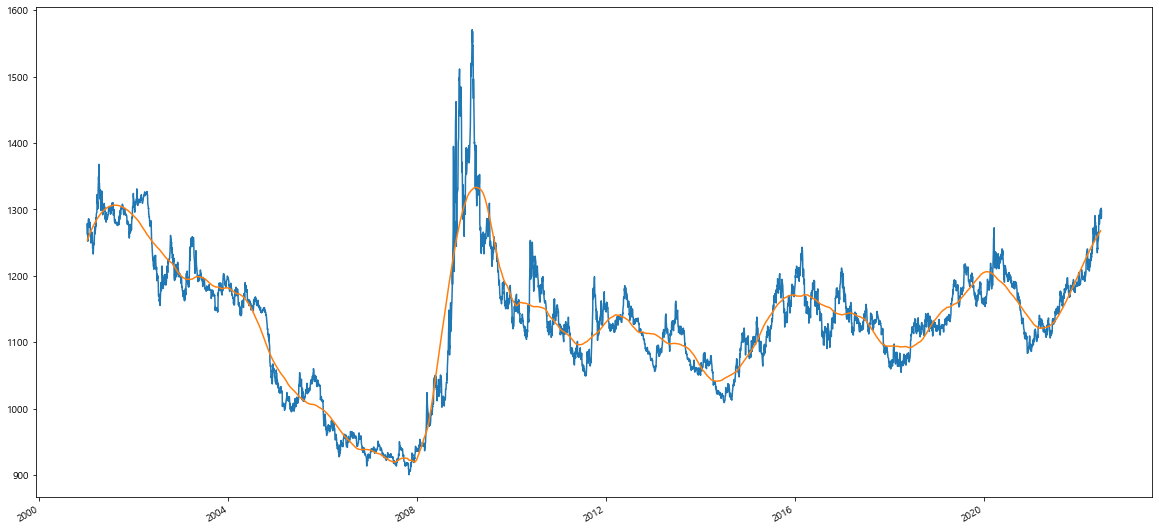

In [194]:
plt.figure(figsize=(20, 10))

data.plot()
plt.plot(m_data)


<AxesSubplot:>

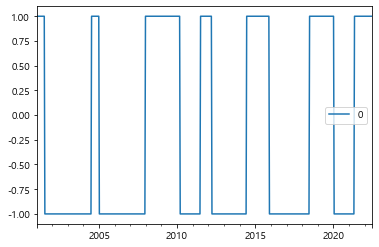

In [195]:

regime_data.plot()

## 다음과 같이 csv파일로 저장하거나  여러 변수들을 데이터 프레임화 시켜서 저장할 수 있습니다.
## 예시로는 각자 저장하여 sector르 찾을때 따로 열어주어 데이터프레임을 합쳤습니다.
## 원달러_이주간.csv파일처럼 인플레,구리등을 추가해보았습니다.
## 투자자가 원하는 다양한 국면을 자동으로 분석해주며 이를 섹터까지 분석해줄 예정입니다

In [137]:


regime_data.to_csv('원달러_이주간.csv')

## 추가적으로 위의 자료는 2000년도 초반부터 현재까지 마르코프국면모델을 실시한 경우이며, 인샘플 아웃샘플을 나누고 싶으면, bactesting 
## 함수를 적용시켜서 이후의 값들을 in-sample데이터로 하나씩 예측해갑니다. 다음의 코드는 2009년 12월 25일부터 하나씩데이터를 늘려가며 예측을 시도한 경우입니다.
## freq를 2주 금요일마다 나타나게끔 하였으므로 날짜를 맞게 설정해야합니다#

In [ ]:

predict=a.backtesting(data,'2009-12-25')


## 위와같이 변수에 따라 국면을 따로 저장한 파일들을 전부 열어 줍니다.
## 굳이 저장할 필요없이 국면데이터들을 데이터프레임으로 결합하여 사용하셔도 무방합니다.
## 예시파일에는 인플레이션(BEI)지수, 구리,원달러,위안화를 사용하였으며, 사용자가 원하는 국면에 따라 자유로이 사용할 수 있게끔 하였습니다.

In [380]:
bond_day = pd.read_csv('인플레_이주간.csv', index_col = 0)
copper_day = pd.read_csv('구리_이주간.csv', index_col = 0)
wd_day = pd.read_csv('원달러_이주간.csv', index_col = 0)
#ch_day = pd.read_csv('위안화_주간.csv', index_col = 0)

In [381]:
co_dt = pd.to_datetime(copper_day.index)
bd_dt = pd.to_datetime(bond_day.index)
wd_dt = pd.to_datetime(wd_day.index)
#ch_dt = pd.to_datetime(ch_day.index)

In [382]:
bond_day.index = bd_dt
copper_day.index = co_dt
wd_day.index = wd_dt
#ch_day.index = ch_dt

In [383]:
co_dt,bd_dt,wd_dt

(DatetimeIndex(['2001-01-19', '2001-02-02', '2001-02-16', '2001-03-02',
                '2001-03-16', '2001-03-30', '2001-04-13', '2001-04-27',
                '2001-05-11', '2001-05-25',
                ...
                '2022-02-18', '2022-03-04', '2022-03-18', '2022-04-01',
                '2022-04-15', '2022-04-29', '2022-05-13', '2022-05-27',
                '2022-06-10', '2022-06-24'],
               dtype='datetime64[ns]', length=560, freq=None),
 DatetimeIndex(['2003-01-17', '2003-01-31', '2003-02-14', '2003-02-28',
                '2003-03-14', '2003-03-28', '2003-04-11', '2003-04-25',
                '2003-05-09', '2003-05-23',
                ...
                '2022-03-04', '2022-03-18', '2022-04-01', '2022-04-15',
                '2022-04-29', '2022-05-13', '2022-05-27', '2022-06-10',
                '2022-06-24', '2022-07-08'],
               dtype='datetime64[ns]', name='DATE', length=509, freq=None),
 DatetimeIndex(['2003-01-17', '2003-01-31', '2003-02-14', '2003-02-

In [384]:
bond_day.columns = ['인플레']
copper_day.columns = ['구리']
wd_day.columns = ['원달러']
#ch_day.columns=['위안화']

In [385]:
copper_day.loc['2010':],bond_day.loc['2010':]

(            구리
 2010-01-08   1
 2010-01-22   1
 2010-02-05   1
 2010-02-19   1
 2010-03-05   1
 ...         ..
 2022-04-29  -1
 2022-05-13  -1
 2022-05-27  -1
 2022-06-10  -1
 2022-06-24  -1
 
 [326 rows x 1 columns],
             인플레
 DATE           
 2010-01-08   -1
 2010-01-22   -1
 2010-02-05   -1
 2010-02-19   -1
 2010-03-05   -1
 ...         ...
 2022-05-13    1
 2022-05-27    1
 2022-06-10    1
 2022-06-24    1
 2022-07-08    1
 
 [327 rows x 1 columns])

In [386]:
data = pd.merge(bond_day.loc['2010':], copper_day.loc['2010':], left_index= True, right_index= True)

In [387]:
data =  pd.merge(data, wd_day.loc['2010':], left_index= True, right_index= True)
#data =  pd.merge(data, ch_day, left_index= True, right_index= True)

In [388]:
data=data.dropna()

In [389]:
data=data.replace(0,1)


## 날짜가 전부 동일하게끔 데이터프레임을 맞춰주었습니다.

In [390]:
data

,인플레,구리,원달러
2010-01-08,-1,1,1
2010-01-22,-1,1,1
2010-02-05,-1,1,1
2010-02-19,-1,1,1
2010-03-05,-1,1,1
...,...,...,...
2022-04-29,1,-1,1
2022-05-13,1,-1,1
2022-05-27,1,-1,1
2022-06-10,1,-1,1


## 다음은 KRX 홈페이지에서 직접 섹터별 지수데이터를 가져와 데이터프레임화 시킨 파일입니다. 영업일 기준으로 변화율로 바꿔줍니다.

In [391]:
index_total = pd.read_csv('0715 섹터 종가.csv', index_col=0, encoding='cp949')
index_total.index = pd.to_datetime((index_total.index))
sectors = index_total.iloc[:,:-1]

In [392]:
sectors=sectors.resample(rule='B').last().ffill().pct_change().dropna()

In [393]:
sectors

,KRX_300 금융 종가,KRX_300 정보기술 종가,KRX_유틸리티 종가,KRX_정보기술 종가,KRX_미디어&엔터테인먼트 종가,KRX_필수소비재 종가,KRX_경기소비재 종가,KRX_운송 종가,KRX_보험 종가,KRX_기계장비 종가,...,kosdaq_건설 종가,kosdaq_제조업 종가,kosdaq_IT 종가,kosdaq_기타서비스 종가,kosdaq_자유소비재 종가,kosdaq_필수소비재 종가,kosdaq_산업재 종가,kosdaq_소재 종가,kosdaq_커뮤니케이션서비스 종가,kosdaq_헬스케어 종가
일자,,,,,,,,,,,,,,,,,,,,,
2015-01-12,-0.023154,0.004001,-0.005587,0.008877,0.002191,0.014627,-0.002789,-0.015202,-0.017635,-0.006019,...,0.003470,0.006604,-0.000464,0.002067,-0.002477,0.007858,0.004079,0.020958,0.007886,0.008942
2015-01-13,-0.001969,-0.012072,-0.007326,-0.008179,-0.027969,0.008380,0.001099,-0.032172,-0.004933,-0.013938,...,-0.000596,0.000147,-0.013941,-0.004380,0.005141,-0.002435,-0.010543,-0.016577,-0.022483,0.011389
2015-01-14,0.012556,0.003308,-0.012732,0.009549,0.008213,-0.005582,-0.000638,-0.018263,0.005206,-0.000517,...,-0.002147,0.002919,0.005575,0.011926,-0.003520,0.017871,0.001760,0.000952,-0.008089,0.006008
2015-01-15,-0.008320,0.016719,0.003284,0.008594,0.034159,0.013633,0.001877,0.000904,-0.001029,-0.011922,...,0.000120,0.011044,0.016259,0.003622,0.005956,0.003994,-0.003562,0.010336,0.030836,0.008294
2015-01-16,-0.019917,-0.015797,-0.013990,-0.019062,-0.000873,-0.000549,-0.011676,-0.002537,-0.027947,-0.026800,...,-0.012433,-0.007675,-0.007033,-0.006687,-0.018598,-0.005228,-0.010577,-0.007046,-0.011490,-0.013525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,-0.004174,0.022763,0.048710,0.022882,-0.004016,0.017840,0.016424,0.021687,0.006707,0.040715,...,0.035011,0.029964,0.024671,0.022510,0.018919,0.013575,0.033749,0.021479,0.017994,0.004001
2022-06-28,0.005449,0.006623,-0.004136,0.006037,-0.008802,0.007041,0.000569,0.010703,0.008444,0.006633,...,0.020490,-0.002119,0.001404,-0.008793,0.003375,-0.004610,-0.007237,0.007557,-0.006370,-0.019452
2022-06-29,-0.026226,-0.019859,-0.021310,-0.020022,-0.027418,0.007115,-0.001761,-0.007516,0.000655,-0.008322,...,0.007604,-0.007674,-0.013969,-0.011630,-0.010329,-0.012219,-0.015730,-0.031260,-0.018411,-0.016373



## 다음 클래스는 국면 데이터프레임과, 섹터데이터프레임을 통해 국면별 아웃퍼폼하는 섹터를 찾아주는 클래스입니다.

## 사용방법은 아래의 예시 사용법을 적어두었습니다.

In [394]:

import numpy as np
        
class regime_analyze:
    def __init__(self,data,sector_data):
        print('알파찾기 시작합니다.')
        self.regime_sys_data=''
        self.origin_data=data
        self.sector_data=sector_data
        
        
        

        stock_list=['KS11','KQ11','KRX100']
        for index,stock in enumerate(stock_list):

            #stock_data=fdr.DataReader(stock,start)
            stock_data=wb.DataReader(stock, '2002')
            close=stock_data.loc[:,'Close']
            Volume=stock_data.loc[:,'Volume']
            #stock_data.columns=[stock+"Close",stock+"Volume"]
            if index==0:
                close_data=pd.DataFrame(close)
                vol_data=pd.DataFrame(Volume)
            else:
                close_data=pd.concat([close_data,pd.DataFrame(close)],axis=1)
                vol_data=pd.concat([vol_data,pd.DataFrame(Volume)],axis=1)
        close_data.index=pd.to_datetime(close_data.index)
        close_data.columns=['코스피','코스닥','KRX']

    
    
        self.benchmark_data=close_data
        
        
        
        self.benchmark_data=self.benchmark_data.resample(rule='D').last().ffill().pct_change().loc[self.sector_data.index,:].dropna()
        self.benchmark_data=self.benchmark_data.dropna()
        print(len(self.sector_data.index),len(self.benchmark_data))
        
        
    #원하는 두 변수를 입력시 두개의 국면 조합에따라 총 4개의 국면이 나오게 합니다.    
    def regime_mix(self,obj1,obj2): 
        
        col=[]
        mix_regime_list=[]
        
        x=data.loc[:,obj1]
        y=data.loc[:,obj2]

        
        if len(x)!=len(y):
            
            print('시계열이 같지 않습니다.')
            return False
        
        
        
        
        for ii in range(len(x)):
            if x[ii] == 1 and y[ii] == 1:
                mix_regime_list.append(0)
            elif x[ii] == 1 and y[ii] == -1:
                mix_regime_list.append(1)
            elif x[ii] == -1 and y[ii] == 1:
                mix_regime_list.append(2)
            elif x[ii] ==-1 and y[ii] ==-1:
                mix_regime_list.append(3)
            else:
                print('에러')
                return False
        if len(self.regime_sys_data)!=0:
            if obj1+obj2 in self.regime_sys_data.columns:
                print('이미 있습니다.')
                return self.regime_sys_data.loc[:,obj1+obj2]
            elif obj2+obj1 in self.regime_sys_data.columns:
                print('이미 있습니다.')
                return self.regime_sys_data.loc[:,obj2+obj1]
            col=list(self.regime_sys_data.columns)
        
        
        new_data=pd.DataFrame(mix_regime_list)
        new_data.index=self.origin_data.index
        if len(col) == 0:
            new_data.columns=[obj1+obj2]
        else:
            print(col,obj1+obj2)
            #col.append()
            
            new_data.columns=[obj1+obj2]
        
        if len(self.regime_sys_data)==0:
            self.regime_sys_data=new_data
            self.regime_sys_data.index=self.origin_data.index
            new_data=pd.DataFrame(new_data)
            new_data.index=self.origin_data.index
        else:
            #try:
            print(self.regime_sys_data,new_data)
            self.regime_sys_data=pd.concat([self.regime_sys_data,new_data],axis=1)
            
            #except:
            #    print('이미 있는 국면입니다.')
            #    return False
            
        return new_data
    
    # self. regime_sys_data에 종합 국면을 저장해줍니다.
    # 이후 put함수에 따라 원하는 종합국면을 골라주고 아웃퍼폼 섹터를 색출해냅니다.
    # 뿐만아니라 start_year을 이용해 연도를 변경해줄 수 있습니다.
    def put(self,sector_data,x,y,change_start_year='',end_year=""):
        if end_year =="":
        
            data=self.regime_sys_data.loc[change_start_year:,:]
        
        else:
            data=self.regime_sys_data.loc[change_start_year:end_year,:]
        
        if y+x in data.columns:
            x,y=y,x
            name= x+y
        else:
            name= x+y
        
        bd_co_day_0 =data[name][(data[name] == 0)]
        bd_co_day_1 =data[name][(data[name] == 1)]
        bd_co_day_2 =data[name][(data[name] == 2)]
        bd_co_day_3 =data[name][(data[name] ==3)]
        #print(bd_co_day_0)
        
        for num in range(4):
            #print('bd_co_day_'+str(num))
            day=eval(f"bd_co_day_{num}")
            print('국면 {} 의 개수는 {}개 입니다. '.format(str(num+1),str(len(day))))
            if len(day) ==0:
                data.plot()
                print('국면의 개수가 0인 국면이 있습니다. 국면의 편차가 크므로 새로 생성하십시오')
                return False
        
        k=self.analyse2(  x, y )

        #print(k)
        return k

    def name_dict(self,x,y,regime):
        if regime==0:
            print('%s 상승,%s 상승'%(x,y))
    
        elif regime==1:
            print('%s 상승,%s 하락'%(x,y))
            
        elif regime==2:
            print('%s 하락,%s 상승'%(x,y))
            
        elif regime==3:
            print('%s 하락,%s 하락'%(x,y))
    
    
    def analyse1(self,input_x,x, y, regime_state):

        data=self.regime_sys_data.loc['2012':,:]

        if y+x in data.columns:
            x,y=y,x
            name= x+y
        else:
            name= x+y

        df=self.regime_sys_data.loc[:,name]

        period_index = df[(df == regime_state) ].index
        
        period_index=[i for i in period_index if i in self.sector_data.index]
        
        x = self.sector_data[input_x].loc[period_index]

        if 'KRX' in input_x:
            y = self.benchmark_data['KRX'].loc[period_index]
        elif 'kosdaq' in input_x:
            y = self.benchmark_data['코스닥'].loc[period_index]
        elif '코스피' in input_x:
            y = self.benchmark_data['코스피'].loc[period_index]
        else:
            print('에러2')

       # y = df[input_y].loc[period_index]
        model = sm.OLS(y, x).fit()
        summ = model.summary()
        line_fitter = LinearRegression()
        line_fitter.fit(x.values.reshape(-1, 1), y)

        beta, alpha = line_fitter.coef_[0], line_fitter.intercept_
        # plt.plot(x, y, 'o')
        # plt.plot(x,line_fitter.predict(x.values.reshape(-1,1)))
        # plt.show()

        x2 = self.sector_data[input_x]
        if 'KRX' in input_x:
            y2 = self.benchmark_data['KRX']
        elif 'kosdaq' in input_x:
            y2 = self.benchmark_data['코스닥']
        elif '코스피' in input_x:
            y2 = self.benchmark_data['코스피']
        else:
            print('에러3')

        model = sm.OLS(y2, x2).fit()
        summ = model.summary()
        line_fitter2 = LinearRegression()
        line_fitter2.fit(x2.values.reshape(-1, 1), y2)

        return (line_fitter.intercept_ - line_fitter2.intercept_)*100




    # 국면 변수 2개 고르면 plt 띄우기

    def analyse2(self,regime1, regime2):
        market_rate_per_r1_r2_0 = {}
        market_rate_per_r1_r2_1 = {}
        market_rate_per_r1_r2_2 = {}
        market_rate_per_r1_r2_3 = {}

        for jj in range(4):


            for input_x in list(self.sector_data.columns[:]):
                #print(input_x)
                if jj == 0:
                    #     print(0)
                    market_rate_per_r1_r2_0[input_x, regime1, regime2] = (
                        self.analyse1(input_x,  regime1, regime2, jj))
                elif jj == 1:
                    #     print(1)
                    market_rate_per_r1_r2_1[input_x, regime1, regime2] = (
                        self.analyse1(input_x,   regime1, regime2, jj))
                elif jj == 2:
                    #     print(2)
                    market_rate_per_r1_r2_2[input_x, regime1, regime2] = (
                        self.analyse1(input_x,   regime1, regime2, jj))
                elif jj == 3 :
                    #   print(3)
                    market_rate_per_r1_r2_3[input_x, regime1, regime2] = (
                        self.analyse1(input_x,   regime1, regime2, jj))
                else:
                    print('에러')

        return (market_rate_per_r1_r2_0, market_rate_per_r1_r2_1, market_rate_per_r1_r2_2, market_rate_per_r1_r2_3)


    


    def draw(self,ccc,  ii, x, y):  # 상위 ii개 그리기
        uu, ud, du, dd = list(ccc[0].values()), list(ccc[1].values()), list(ccc[2].values()), list(ccc[3].values())
        uu.sort(reverse=True)
        ud.sort(reverse=True)
        du.sort(reverse=True)
        dd.sort(reverse=True)

        reverse_dictionary_0= dict(map(reversed,ccc[0].items()))
        reverse_dictionary_1= dict(map(reversed,ccc[1].items()))
        reverse_dictionary_2= dict(map(reversed,ccc[2].items()))
        reverse_dictionary_3= dict(map(reversed,ccc[3].items()))

        print(reverse_dictionary_0)
        plt.figure(figsize=(50, 20))


        k=1.5
        for kk in range(ii):
            if uu[kk]>0 :

                plt.text(   (ii-kk)*k, (ii-kk)*k     ,reverse_dictionary_0[uu[kk]][:][0].replace('종가',""), fontsize=30  )
            if ud[kk]>0 :
                plt.text(   (ii-kk)*k, -(ii-kk)*k     ,reverse_dictionary_1[ud[kk]][:][0].replace('종가',""), fontsize=30 )
            if du[kk]>0 :
                plt.text(   -(ii-kk)*k, (ii-kk)*k    ,reverse_dictionary_2[du[kk]][:][0].replace('종가',""), fontsize=30 )
            if dd[kk]>0 :
                plt.text(   -(ii-kk)*k, -(ii-kk)*k    ,reverse_dictionary_3[dd[kk]][:][0].replace('종가',""), fontsize=30 )


        plt.rcParams['font.family'] ='Malgun Gothic'

        plt.rcParams['axes.unicode_minus'] =False

        plt.Xlabel = x
        plt.ylabel = y

        plt.xticks(np.arange(-10, 15, 5))
        plt.yticks(np.arange(-10, 15, 5))
        plt.axvline(x=1, color='b', linestyle='--')

        plt.axhline(y=0, color='b', linestyle='--')

        box = {'boxstyle': 'square',
            'ec': (0.3, 1.0, 0.5),
            'fc': (0.8, 1.0, 0.5),
            'linestyle': '-.',
            'linewidth': 2}

        plt.text(   8,0      ,x+'상승국면', fontsize=40 ,bbox=box  )
        plt.text(   0,9      ,y+'상승국면', fontsize=40 ,bbox=box )
        plt.text(   -10,0      ,x+'하락국면', fontsize=40 ,bbox=box )
        plt.text(   0,-9.5      ,y+'하락국면', fontsize=40 ,bbox=box )


        plt.show()
    
    def sector_find(self, factor1,factor2,start):
        
        mix_data=self.regime_mix(factor1,factor2)
        
        last_day=mix_data.index[-1]
        
        
        start_day=datetime.datetime.strptime(start, "%Y-%m-%d")
        #start_day=mix_data.loc[:]
        
        print(start_day)
        num=0
        day_list=[]
        while start_day < last_day:
            now_regime=mix_data.loc[start_day]
            #know_regime=mix_data.loc[:start_day]
            regime_sector=self.put(self.sector_data,factor1,factor2,'2010',start_day)
        
            print('d',start_day)
            sector_data=self.sector_data.loc[:start_day]
            
            
            uu, ud, du, dd = list(regime_sector[0].values()), list(regime_sector[1].values()), list(regime_sector[2].values()), list(regime_sector[3].values())
            uu.sort(reverse=True)
            ud.sort(reverse=True)
            du.sort(reverse=True)
            dd.sort(reverse=True)

            reverse_dictionary_0= dict(map(reversed,regime_sector[0].items()))
            reverse_dictionary_1= dict(map(reversed,regime_sector[1].items()))
            reverse_dictionary_2= dict(map(reversed,regime_sector[2].items()))
            reverse_dictionary_3= dict(map(reversed,regime_sector[3].items()))
            stock_list=[]
            for kk in range(3):
                if now_regime ==0 :
                    stock=reverse_dictionary_0[uu[kk]][:][0]
                elif now_regime ==1 :
                    stock=reverse_dictionary_1[ud[kk]][:][0]
                elif now_regime ==2:
                    stock=reverse_dictionary_2[du[kk]][:][0]
                elif now_regime ==3:
                    stock=reverse_dictionary_3[dd[kk]][:][0]

                stock_list.append(stock)
            
            if num==0:
                stock_pd=pd.DataFrame(stock_list).T
            else:
                stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
            
            print(stock_pd)
            
            day_list.append(start_day)
            start_day+= datetime.timedelta(weeks=2)
            
        
            num+=1
        #factor1=regime_pd.loc[factor1]
        #factor2=regime_pd.loc[factor2]
        
        
        stock_pd.index=day_list
        
        return  stock_pd    
        
    
        



    

## 먼저 클래스를 실행합니다.
## 이후 초기에 가져온 국면변수를 두개 설정하여 regime_mix 함수를 실행하면 4개의 국면이 색출됩니다.
## 혼합된 국면은 regime_sys_data로 확인 가능합니다.
## put함수를 이용해 섹터별 해당 국면의 초과 수익률을 확인하는 과정을 거칩니다.
## 그 결과를 draq 함수를 통해 확인할 수 있습니다.

In [395]:
a=regime_analyze(data,sectors)

알파찾기 시작합니다.


C:\Users\User\anaconda3\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)
C:\Users\User\anaconda3\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)


1950 1950


In [396]:
b=a.regime_mix('구리','원달러')
print(b)



            구리원달러
2010-01-08      0
2010-01-22      0
2010-02-05      0
2010-02-19      0
2010-03-05      0
...           ...
2022-04-29      2
2022-05-13      2
2022-05-27      2
2022-06-10      2
2022-06-24      2

[326 rows x 1 columns]


In [397]:


a.regime_sys_data
#a.analyse2('코스피 기하 수익률 5일', index_total, data, '인플레', '원달러' )

,구리원달러
2010-01-08,0
2010-01-22,0
2010-02-05,0
2010-02-19,0
2010-03-05,0
...,...
2022-04-29,2
2022-05-13,2
2022-05-27,2
2022-06-10,2


In [398]:

last=a.put(sectors,'구리','원달러','2012')


국면 1 의 개수는 11개 입니다. 
국면 2 의 개수는 70개 입니다. 
국면 3 의 개수는 104개 입니다. 
국면 4 의 개수는 89개 입니다. 


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

## 원점에서 멀어질수록 초과수익률이 더 높은 섹터입니다.

{0.05726406126864655: ('KRX_300 금융 종가', '구리', '원달러'), -0.1787672547710791: ('KRX_300 정보기술 종가', '구리', '원달러'), 0.11898250054271087: ('KRX_유틸리티 종가', '구리', '원달러'), -0.20404248396697608: ('KRX_정보기술 종가', '구리', '원달러'), 0.14205033201299666: ('KRX_미디어&엔터테인먼트 종가', '구리', '원달러'), 0.5309354833579666: ('KRX_필수소비재 종가', '구리', '원달러'), -0.05381756757546095: ('KRX_경기소비재 종가', '구리', '원달러'), 0.0709895825928752: ('KRX_운송 종가', '구리', '원달러'), 0.046368172915871274: ('KRX_보험 종가', '구리', '원달러'), 0.06592980747154464: ('KRX_기계장비 종가', '구리', '원달러'), -0.0635388257152871: ('KRX_증권 종가', '구리', '원달러'), 0.20741098079886536: ('KRX_건설 종가', '구리', '원달러'), 0.10096679420978988: ('KRX_방송통신 종가', '구리', '원달러'), 0.05629293076407264: ('KRX_철강 종가', '구리', '원달러'), -0.22191350343596225: ('KRX_에너지화학 종가', '구리', '원달러'), 0.09775564890896142: ('KRX_은행 종가', '구리', '원달러'), 0.05677412298770662: ('KRX_헬스케어 종가', '구리', '원달러'), -0.12564042471829112: ('KRX_반도체 종가', '구리', '원달러'), 0.05697776219506331: ('KRX_자동차 종가', '구리', '원달러'), 0.5922400161886248: ('KRX 

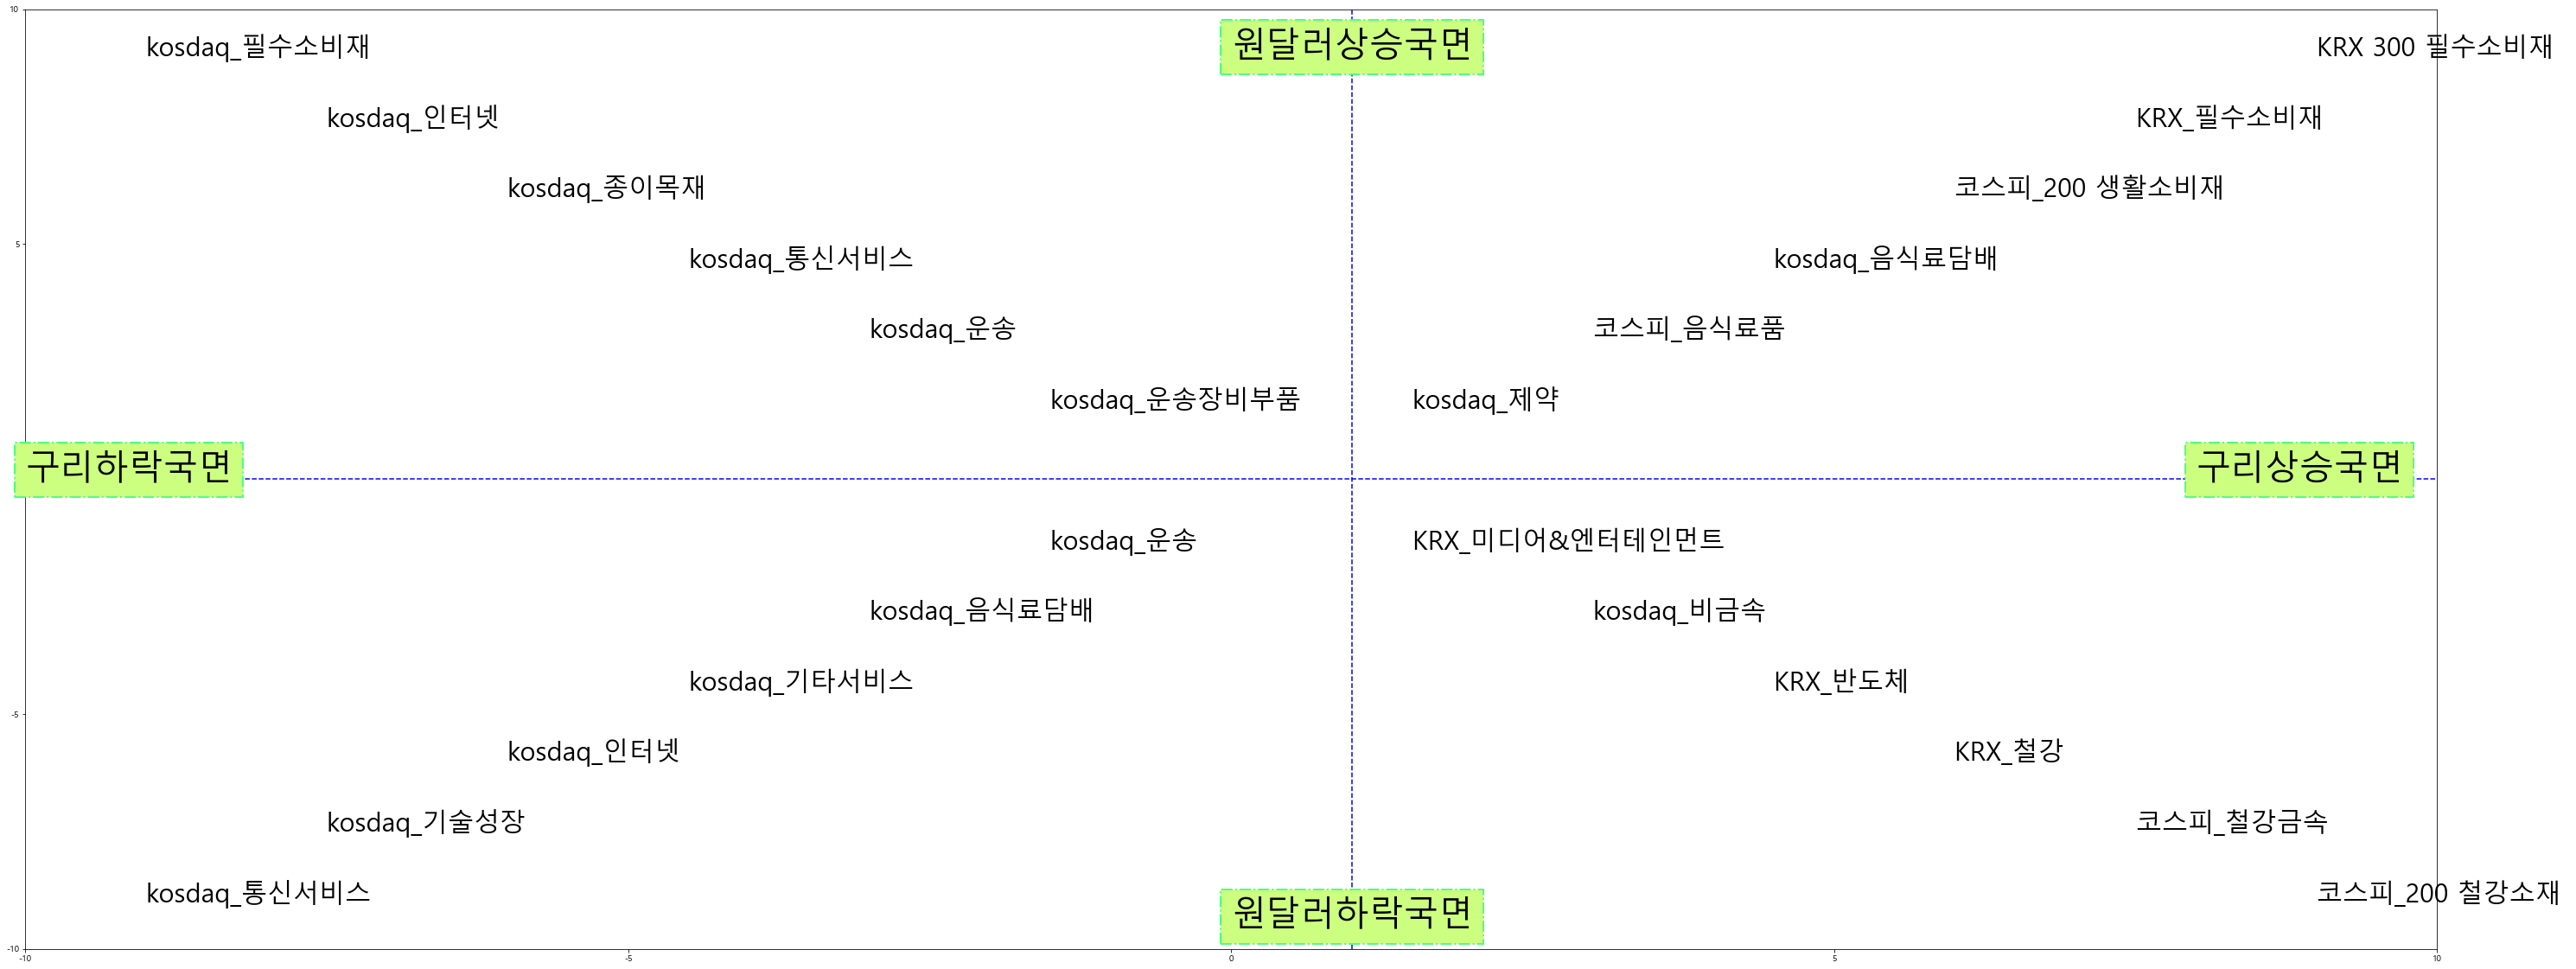

In [399]:
# 한글이 꺠질경우 다음의 코드를 실행하십시오

plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False

# 6은 각 국면마다 상위 6개를 뽑아오게 하기 위함입니다.     

a.draw(last,6,'구리','원달러')


## 본 코드는 구리와 원달러의 국면으로 이루어진 예시코드이며, 다양한 변수로 활용될 수 있기에 
## 개인투자자들이 원하는 변수를 입력하여 어떤 주식이 과거에 통계적으로 아웃퍼폼하였는지 관찰할 수 있는 시스템을 구축해보았습니다.

## 다음은 실제로 국면을 활용하여 투자시 어느정도 효과를 보는지 알기 위해 백테스팅 코드를 작성해보았습니다.
## sector_find 함수는 in-sample 데이터에서 국면데이터를 활용해 국면을 나눈뒤 아웃퍼폼 섹터를 찾아주는 함수입니다.
## 2주마다 다음 국면을 예측한 뒤, 해당 국면에 가장 수익률이 통계적으로 좋았던 섹터 3개의 수익률을 비교해보았습니다.

In [433]:
backtest_data=a.sector_find('구리','원달러','2021-01-08')

이미 있습니다.
2021-01-08 00:00:00
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 86개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-01-08 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 87개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-01-22 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 88개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-02-05 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 89개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-02-19 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 90개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-03-05 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 91개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-03-19 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 92개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-04-02 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 93개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-04-16 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 5개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-04-30 00:00:00
                 0            1          2
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
0  코스피_200 철강소재 종가  코스피_철강금속 종가  KRX_철강 종가
국면 1 의 개수는 6개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-05-14 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 7개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-05-28 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 8개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-06-11 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 9개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-06-25 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 10개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-07-09 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 11개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-07-23 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 12개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-08-06 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 13개 입니다. 
국면 2 의 개수는 94개 입니다. 
국면 3 의 개수는 98개 입니다. 
국면 4 의 개수는 99개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-08-20 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
국면 1 의 개수는 14개 입니다. 
국면 2 의 개수는 94개 입니다. 


C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-09-03 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-09-17 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-10-01 00:00:00
                  0             1                 2
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가   코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가  KRX_필수소비재 종가  코스피_200

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-10-15 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-10-29 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-11-12 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-11-26 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-12-10 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2021-12-24 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-01-07 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-01-21 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-02-04 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-02-18 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-03-04 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-03-18 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-04-01 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-04-15 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-04-29 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-05-13 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-05-27 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid fo

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnin

d 2022-06-10 00:00:00
                  0              1                 2
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0   코스피_200 철강소재 종가    코스피_철강금속 종가         KRX_철강 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KRX_필수소비재 종가  코스피_200 생활소비재 종가
0  KRX 300 필수소비재 종가   KR

C:\Users\User\AppData\Local\Temp\ipykernel_11904\2354238576.py:358: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)


## 다음과 같이 21년도 1월부터 투자할경우 국면에 따라 업종 3개를 2주마다 뽑았습니다.

In [434]:
backtest_data

,0,1,2
2021-01-08,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-01-22,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-02-05,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-02-19,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-03-05,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-03-19,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-04-02,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-04-16,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-04-30,코스피_200 철강소재 종가,코스피_철강금속 종가,KRX_철강 종가
2021-05-14,KRX 300 필수소비재 종가,KRX_필수소비재 종가,코스피_200 생활소비재 종가


In [435]:
index_total = pd.read_csv('0715 섹터 종가.csv', index_col=0, encoding='cp949')
index_total.index = pd.to_datetime((index_total.index))
sectors = index_total.iloc[:,:-1]

## 백테스팅 함수는 위에서 만든 날짜별 섹터를 입력하면 자동으로 close_data 에서 종가를 가져와 수익률을 날짜마다 구해서 데이터프레임화 시킵니다.

In [468]:
def backtesting(df,close_data,market):
    
    #ror_dict = dict()
    df_ror=[]
    df_bench=[]
    height = df.shape[0]
    width = df.shape[1]
    
    dates = df.index
    
#     print(height)



    stock_list=['KS11','KQ11','KRX100']
    for index,stock in enumerate(stock_list):

        #stock_data=fdr.DataReader(stock,start)
        stock_data=wb.DataReader(stock, '2002')
        close=stock_data.loc[:,'Close']
        Volume=stock_data.loc[:,'Volume']
        #stock_data.columns=[stock+"Close",stock+"Volume"]
        if index==0:
            close_data1=pd.DataFrame(close)
            vol_data=pd.DataFrame(Volume)
        else:
            close_data1=pd.concat([close_data1,pd.DataFrame(close)],axis=1)
            vol_data=pd.concat([vol_data,pd.DataFrame(Volume)],axis=1)
    close_data1.index=pd.to_datetime(close_data1.index)
    close_data1.columns=['코스피','코스닥','KRX']



    bench_data=close_data1
        
    
    
    
    for i in range(height-1):

        temp_df = df.iloc[i,:]

        start_date = dates[i]
        end_date = dates[i+1]

#             print(start_date)
#             print(end_date)

        for j in range(width):
            ror=0

            ticker = temp_df[j]


            buy_close = close_data.loc[start_date,ticker]
            print(buy_close)

            sell_close= close_data.loc[end_date,ticker]
            
            
            buy_bench=bench_data.loc[start_date,market]
            sell_bench=bench_data.loc[end_date,market]
            
            #data.loc[end_date,'kospi']

            ror += (sell_close - buy_close)/buy_close
                
            ror1 = (sell_bench-buy_bench)/buy_bench
            
        avg_ror=ror/(width)


                        
                        
        df_bench.append(ror1)
        df_ror.append(avg_ror)
    
    df_ror=pd.DataFrame(df_ror)
    df_ror.index=dates[:-1]
    df_bench=pd.DataFrame(df_bench)
    df_bench.index=dates[:-1]
    return df_ror,df_bench
#     return ror_dict




In [475]:
yy,yy_bench = backtesting(backtest_data,sectors,'KRX')    
yy

C:\Users\User\anaconda3\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)
C:\Users\User\anaconda3\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)


816.58
4494.82
1590.96
769.38
4174.99
1505.12
752.71
4112.86
1450.37
761.69
4141.98
1471.59
819.65
4609.05
1627.78
806.21
4415.15
1592.71
861.41
4755.33
1705.7
957.06
5132.79
1899.32
1066.43
5616.1
2128.92
1836.63
1854.79
1232.21
1852.09
1866.71
1249.71
1851.4
1868.08
1259.49
1868.64
1894.62
1265.0
1790.12
1825.55
1212.91
1759.01
1801.01
1199.03
1744.59
1779.76
1193.62
1652.2
1682.58
1124.3
1717.83
1741.64
1167.94
1644.63
1671.46
1134.76
1564.55
1590.64
1086.49
729.98
19603.17
22024.43
743.32
19208.72
19999.25
698.93
18390.19
23307.81
706.85
17888.71
22788.72
748.34
17904.27
21256.92
691.55
17688.56
20545.98
753.74
17511.98
20306.58
719.18
16628.05
18926.56
760.05
16246.37
17639.51
831.44
15928.49
17325.7
856.97
16067.18
17633.41
810.53
16782.78
17582.25
798.59
16907.11
18324.17
803.55
16785.91
19020.41
801.4
16300.86
18765.28
803.12
15607.68
18213.19
765.88
15362.79
17957.23


,0
2021-01-08,-0.017985
2021-01-22,-0.012125
2021-02-05,0.004877
2021-02-19,0.035379
2021-03-05,-0.007182
2021-03-19,0.023647
2021-04-02,0.037838
2021-04-16,0.040295
2021-04-30,0.010567
2021-05-14,0.004734


## yy_bench 는 KRX 지수의 수익률이며, yy는 국면을 활용 하였을때의 수익률입니다.
## 히스토그램과 다양한 통계적 분포를 살펴본 결과, 수익률 및 위험도가 개선된 형태를 나타내는 결과를 보입니다.
## 이는 물론 21년 1월 구리 원달러 국면 기준이며, 투자자가 더욱 다양한 국면을 활용하여 투자 백테스팅을 해볼 수 있음을 기대합니다.

In [484]:
yy_bench.describe()

,0
count,37.000000
mean,-0.006620
std,0.022621
min,-0.068308
25%,-0.023829
50%,-0.005470
75%,0.009437
max,0.043022


In [479]:

yy.describe()

,0
count,37.000000
mean,0.000414
std,0.019017
min,-0.030651
25%,-0.011148
50%,-0.003884
75%,0.008581
max,0.055145


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

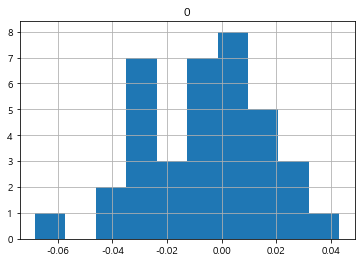

In [482]:
yy_bench.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

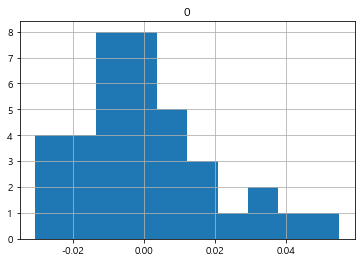

In [483]:
yy.hist()

In [491]:
money=1000
bench_money=1000
money_list=[]
bench_money_list=[]
for i , j in zip(yy.values,yy_bench.values):
    
    money*=(1+i)
    bench_money*=(1+j)
    
    money_list.append(money[0])
    bench_money_list.append(bench_money[0])
    #print(money)

## 실제 21년도 1월부터 투자시 투자금액의 변동양상입니다.
## 벤치마크는 횡보하거나 꾸준히 하락한 반면 국면 활용 모델은 다소 하락을 방어하는 모습을 보입니다.

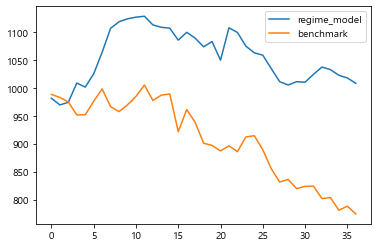

In [496]:
plt.plot(pd.DataFrame(money_list),label='regime_model')
plt.plot(pd.DataFrame(bench_money_list),label = 'benchmark')
plt.legend()